<a href="https://colab.research.google.com/github/RajidiSahithi/Session_09/blob/main/S09_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%pip install albumentations==0.4.6
#%pip install  torch_lr_finder
%pip install torch


In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import transforms

torch.manual_seed(1)


def get_a_train_transform():
    """Get transformer for training data

    Returns:
        Compose: Composed transformations
    """
    return A.Compose([

        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.PadIfNeeded(min_height=36, min_width=36, p=1.0),
        A.RandomCrop (32, 32, always_apply=False, p=1.0),
        A.CenterCrop(32, 32, always_apply=False, p=1.0),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                        fill_value=(0.4914, 0.4822, 0.4465), always_apply=False, p=0.5),
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616), always_apply = True
        ),
        ToTensorV2()
        ])



def get_a_test_transform():
    """Get transformer for test data

    Returns:
        Compose: Composed transformations
    """
    return A.Compose([
         A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), always_apply = True),
                                  ToTensorV2()
    ])





In [7]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor


torch.manual_seed(1)


class Cifar10SearchDataset(Dataset):
    """
    Custom Dataset Class

    """

    def __init__(self, dataset, transforms=None):
        """Initialize Dataset

        Args:
            dataset (Dataset): Pytorch Dataset instance
            transforms (Transform.Compose, optional): Tranform function instance. Defaults to None.
        """
        self.transforms = transforms
        self.dataset = dataset

    def __len__(self):
        """Get dataset length

        Returns:
            int: Length of dataset
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """Get an item form dataset

        Args:
            idx (int): id of item in dataset

        Returns:
            (tensor, int): Return tensor of transformer image, label
        """
        # Read Image and Label
        image, label = self.dataset[idx]#,self.targets[idx]

        image = np.array(image)

        # Apply Transforms
        if self.transforms is not None:
            image = (self.transforms(image=image))["image"]


        return (image, label)


def get_loader(train_transform, test_transform, batch_size=128, use_cuda=True):
    """Get instance of tran and test loaders
    self.batch_size = 128
        self.device = device
        self.use_cuda = use_cuda
    Args:
        train_transform (Transform): Instance of transform function for training
        test_transform (Transform): Instance of transform function for validation
        batch_size (int, optional): batch size to be uised in training. Defaults to 64.
        use_cuda (bool, optional): Enable/Disable Cuda Gpu. Defaults to True.

    Returns:
        (DataLoader, DataLoader): Get instance of train and test data loaders
    """
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

    train_loader = DataLoader(
        Cifar10SearchDataset(datasets.CIFAR10('../data', train=True,
                    download=True), transforms=train_transform),
        batch_size=batch_size, shuffle=True, **kwargs)

    test_loader = DataLoader(
        Cifar10SearchDataset(datasets.CIFAR10('../data', train=False,
                    download=True), transforms=test_transform),
        batch_size=batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


In [8]:
batch_size = 128
use_cuda=True
train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)


print(get_a_train_transform())

print(get_a_test_transform())

print(train_loader)
print('length of train_loader',len(train_loader))
print(test_loader)
print('length of test_loader',len(test_loader))


Files already downloaded and verified
Files already downloaded and verified
Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.05, 0.05), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None),
  PadIfNeeded(always_apply=False, p=1.0, min_height=36, min_width=36, border_mode=4, value=None, mask_value=None),
  RandomCrop(always_apply=False, p=1.0, height=32, width=32),
  CenterCrop(always_apply=False, p=1.0, height=32, width=32),
  CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16),
  Normalize(always_apply=True, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Compose([
  Normalize(always_apply=True, p=1.0, m

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader



def print_samples(loader, count=16):
    """Print samples input images

    Args:
        loader (DataLoader): dataloader for training data
        count (int, optional): Number of samples to print. Defaults to 16.
    """
    # Print Random Samples
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    if not count % 8 == 0:
        return
    fig = plt.figure(figsize=(15, 5))
    for imgs, labels in loader:
        for i in range(count):
            ax = fig.add_subplot(int(count/8), 8, i + 1, xticks=[], yticks=[])
            ax.set_title(f'{classes[labels[i]]}')
            plt.imshow(imgs[i].numpy().transpose(1, 2, 0))
        break


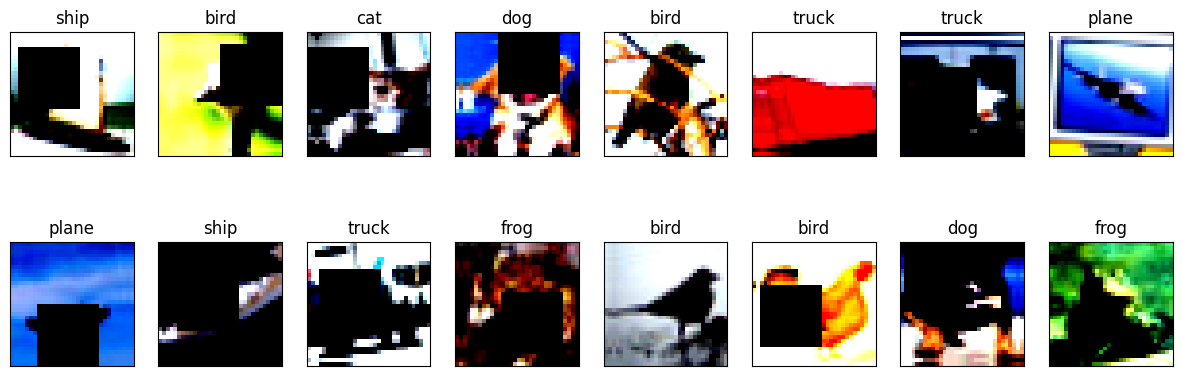

In [10]:
print_samples(train_loader)

In [11]:
batch = iter(train_loader)
images, labels = next(batch)
print(images.shape) # torch.Size([num_samples, in_channels, H, W])
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [17]:
import torch.nn.functional as F
import torch
import torch.nn as nn

dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1, stride=2, bias=False,dilation=2),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, groups=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3) , padding=1, stride=2, bias=False,dilation=2),
        ) # output_size = 16/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, groups=64,kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

def model_summary(model,input_size):
    model = Net().to(device)
    summary(model, input_size=(3, 32, 32))
    return model,input_size

In [18]:
import torch
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

def train_model(model, device, train_loader, optimizer, epoch):
    train_losses = []
    #test_losses = []
    train_acc = []
    #test_acc = []
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm

      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)

def test_model(model, device, test_loader):
    test_losses = []
    test_acc = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


In [19]:
%pip install torchsummary
from torchsummary import summary
#from modular.model import Net
#from modular.training import train_model,test_model
#from modular.utils import get_lr,denormalize

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 15, 15]          18,432
           Conv2d-10           [-1, 64, 15, 15]          18,432
             ReLU-11           [-1, 64, 15, 15]               0
      BatchNorm2d-12           [-1, 64, 15, 15]             128
          Dropout-13           [-1, 64, 15, 15]               0
           Conv2d-14           [-1

In [21]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(2, 2), bias=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.9)
# The StepLR scheduler is used to decay the learning rate of each parameter group
#by gamma every step_size epochs1. To improve the accuracy of the scheduler,
#you can try adjusting the step_size and gamma parameters.
#A smaller step_size will result in more frequent updates to the learning rate,
# while a larger gamma will result in a larger decrease in the learning rate at each update


EPOCHS = 150
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_model(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_model(model, device, test_loader)

EPOCH: 0


Loss=1.5554847717285156 Batch_id=390 Accuracy=39.40: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]



Test set: Average loss: 1.3450, Accuracy: 5169/10000 (51.69%)

EPOCH: 1


Loss=1.2949020862579346 Batch_id=390 Accuracy=51.74: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]



Test set: Average loss: 1.1431, Accuracy: 5886/10000 (58.86%)

EPOCH: 2


Loss=1.1270482540130615 Batch_id=390 Accuracy=57.29: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]



Test set: Average loss: 1.0925, Accuracy: 6162/10000 (61.62%)

EPOCH: 3


Loss=1.1694178581237793 Batch_id=390 Accuracy=60.90: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s]



Test set: Average loss: 0.9554, Accuracy: 6603/10000 (66.03%)

EPOCH: 4


Loss=0.8590523600578308 Batch_id=390 Accuracy=64.01: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s]



Test set: Average loss: 0.8989, Accuracy: 6851/10000 (68.51%)

EPOCH: 5


Loss=0.8717893362045288 Batch_id=390 Accuracy=65.74: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]



Test set: Average loss: 0.8478, Accuracy: 7048/10000 (70.48%)

EPOCH: 6


Loss=0.8406358957290649 Batch_id=390 Accuracy=67.16: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]



Test set: Average loss: 0.7445, Accuracy: 7403/10000 (74.03%)

EPOCH: 7


Loss=0.9457622766494751 Batch_id=390 Accuracy=68.69: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]



Test set: Average loss: 0.7333, Accuracy: 7427/10000 (74.27%)

EPOCH: 8


Loss=0.9389138221740723 Batch_id=390 Accuracy=69.89: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s]



Test set: Average loss: 0.7180, Accuracy: 7513/10000 (75.13%)

EPOCH: 9


Loss=0.9102581143379211 Batch_id=390 Accuracy=70.72: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s]



Test set: Average loss: 0.7179, Accuracy: 7537/10000 (75.37%)

EPOCH: 10


Loss=0.7187082767486572 Batch_id=390 Accuracy=71.63: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 0.7282, Accuracy: 7496/10000 (74.96%)

EPOCH: 11


Loss=0.7111868858337402 Batch_id=390 Accuracy=72.46: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]



Test set: Average loss: 0.6757, Accuracy: 7642/10000 (76.42%)

EPOCH: 12


Loss=0.5541906952857971 Batch_id=390 Accuracy=72.93: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]



Test set: Average loss: 0.6416, Accuracy: 7833/10000 (78.33%)

EPOCH: 13


Loss=0.7883222103118896 Batch_id=390 Accuracy=73.70: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]



Test set: Average loss: 0.6299, Accuracy: 7845/10000 (78.45%)

EPOCH: 14


Loss=0.8990227580070496 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:30<00:00, 12.79it/s]



Test set: Average loss: 0.6567, Accuracy: 7781/10000 (77.81%)

EPOCH: 15


Loss=0.899077296257019 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:31<00:00, 12.33it/s]



Test set: Average loss: 0.6318, Accuracy: 7842/10000 (78.42%)

EPOCH: 16


Loss=0.45155733823776245 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.6073, Accuracy: 7898/10000 (78.98%)

EPOCH: 17


Loss=0.5600212812423706 Batch_id=390 Accuracy=75.48: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]



Test set: Average loss: 0.6230, Accuracy: 7873/10000 (78.73%)

EPOCH: 18


Loss=0.7115989923477173 Batch_id=390 Accuracy=75.89: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]



Test set: Average loss: 0.5838, Accuracy: 8005/10000 (80.05%)

EPOCH: 19


Loss=0.5663703680038452 Batch_id=390 Accuracy=76.17: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]



Test set: Average loss: 0.5447, Accuracy: 8153/10000 (81.53%)

EPOCH: 20


Loss=0.74554443359375 Batch_id=390 Accuracy=76.76: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]



Test set: Average loss: 0.5632, Accuracy: 8090/10000 (80.90%)

EPOCH: 21


Loss=0.7530107498168945 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]



Test set: Average loss: 0.5788, Accuracy: 8030/10000 (80.30%)

EPOCH: 22


Loss=0.6733984351158142 Batch_id=390 Accuracy=77.13: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]



Test set: Average loss: 0.5586, Accuracy: 8090/10000 (80.90%)

EPOCH: 23


Loss=0.6433866024017334 Batch_id=390 Accuracy=77.51: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]



Test set: Average loss: 0.5428, Accuracy: 8148/10000 (81.48%)

EPOCH: 24


Loss=0.548521876335144 Batch_id=390 Accuracy=77.91: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]



Test set: Average loss: 0.5322, Accuracy: 8176/10000 (81.76%)

EPOCH: 25


Loss=0.5256861448287964 Batch_id=390 Accuracy=78.09: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]



Test set: Average loss: 0.5391, Accuracy: 8199/10000 (81.99%)

EPOCH: 26


Loss=0.7219403982162476 Batch_id=390 Accuracy=78.13: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s]



Test set: Average loss: 0.5276, Accuracy: 8186/10000 (81.86%)

EPOCH: 27


Loss=0.7947381734848022 Batch_id=390 Accuracy=78.36: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]



Test set: Average loss: 0.5444, Accuracy: 8163/10000 (81.63%)

EPOCH: 28


Loss=0.6246210336685181 Batch_id=390 Accuracy=78.91: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]



Test set: Average loss: 0.5275, Accuracy: 8243/10000 (82.43%)

EPOCH: 29


Loss=0.6592859029769897 Batch_id=390 Accuracy=78.79: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]



Test set: Average loss: 0.5098, Accuracy: 8253/10000 (82.53%)

EPOCH: 30


Loss=0.6553742289543152 Batch_id=390 Accuracy=79.03: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]



Test set: Average loss: 0.5045, Accuracy: 8288/10000 (82.88%)

EPOCH: 31


Loss=0.6122879981994629 Batch_id=390 Accuracy=79.33: 100%|██████████| 391/391 [00:29<00:00, 13.24it/s]



Test set: Average loss: 0.5162, Accuracy: 8229/10000 (82.29%)

EPOCH: 32


Loss=0.3802465796470642 Batch_id=390 Accuracy=79.42: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 0.5132, Accuracy: 8256/10000 (82.56%)

EPOCH: 33


Loss=0.5997706651687622 Batch_id=390 Accuracy=79.75: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]



Test set: Average loss: 0.5060, Accuracy: 8252/10000 (82.52%)

EPOCH: 34


Loss=0.49302491545677185 Batch_id=390 Accuracy=79.75: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s]



Test set: Average loss: 0.4939, Accuracy: 8334/10000 (83.34%)

EPOCH: 35


Loss=0.4493473470211029 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]



Test set: Average loss: 0.5116, Accuracy: 8248/10000 (82.48%)

EPOCH: 36


Loss=0.5257244110107422 Batch_id=390 Accuracy=80.38: 100%|██████████| 391/391 [00:31<00:00, 12.29it/s]



Test set: Average loss: 0.4946, Accuracy: 8336/10000 (83.36%)

EPOCH: 37


Loss=0.4962511956691742 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]



Test set: Average loss: 0.4862, Accuracy: 8360/10000 (83.60%)

EPOCH: 38


Loss=0.5856460332870483 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]



Test set: Average loss: 0.4921, Accuracy: 8339/10000 (83.39%)

EPOCH: 39


Loss=0.5879001617431641 Batch_id=390 Accuracy=80.45: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]



Test set: Average loss: 0.4921, Accuracy: 8292/10000 (82.92%)

EPOCH: 40


Loss=0.6166195869445801 Batch_id=390 Accuracy=80.89: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]



Test set: Average loss: 0.4771, Accuracy: 8360/10000 (83.60%)

EPOCH: 41


Loss=0.869876503944397 Batch_id=390 Accuracy=80.82: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]



Test set: Average loss: 0.4861, Accuracy: 8374/10000 (83.74%)

EPOCH: 42


Loss=0.45778578519821167 Batch_id=390 Accuracy=81.00: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]



Test set: Average loss: 0.4735, Accuracy: 8392/10000 (83.92%)

EPOCH: 43


Loss=0.5482988953590393 Batch_id=390 Accuracy=81.08: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]



Test set: Average loss: 0.4969, Accuracy: 8340/10000 (83.40%)

EPOCH: 44


Loss=0.45596495270729065 Batch_id=390 Accuracy=81.34: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]



Test set: Average loss: 0.4775, Accuracy: 8382/10000 (83.82%)

EPOCH: 45


Loss=0.52181476354599 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]



Test set: Average loss: 0.4648, Accuracy: 8412/10000 (84.12%)

EPOCH: 46


Loss=0.7161731123924255 Batch_id=390 Accuracy=81.37: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]



Test set: Average loss: 0.4627, Accuracy: 8448/10000 (84.48%)

EPOCH: 47


Loss=0.5291768312454224 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s]



Test set: Average loss: 0.4687, Accuracy: 8393/10000 (83.93%)

EPOCH: 48


Loss=0.5933954119682312 Batch_id=390 Accuracy=81.79: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]



Test set: Average loss: 0.4743, Accuracy: 8382/10000 (83.82%)

EPOCH: 49


Loss=0.4560315012931824 Batch_id=390 Accuracy=81.83: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]



Test set: Average loss: 0.4636, Accuracy: 8427/10000 (84.27%)

EPOCH: 50


Loss=0.5438108444213867 Batch_id=390 Accuracy=81.84: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]



Test set: Average loss: 0.4683, Accuracy: 8420/10000 (84.20%)

EPOCH: 51


Loss=0.45253387093544006 Batch_id=390 Accuracy=81.98: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s]



Test set: Average loss: 0.4625, Accuracy: 8457/10000 (84.57%)

EPOCH: 52


Loss=0.5272021889686584 Batch_id=390 Accuracy=82.05: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s]



Test set: Average loss: 0.4575, Accuracy: 8476/10000 (84.76%)

EPOCH: 53


Loss=0.2848380208015442 Batch_id=390 Accuracy=82.07: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]



Test set: Average loss: 0.4529, Accuracy: 8501/10000 (85.01%)

EPOCH: 54


Loss=0.42756423354148865 Batch_id=173 Accuracy=82.40:  45%|████▍     | 174/391 [00:12<00:16, 13.42it/s]


KeyboardInterrupt: ignored

In [23]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")


Total convolution layers: 10
conv_layers


In [27]:
image = image.unsqueeze(0)
image = image.to(device)

In [28]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

10
torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 15, 15])
torch.Size([1, 64, 15, 15])
torch.Size([1, 64, 15, 15])
torch.Size([1, 32, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 5, 5])
torch.Size([1, 10, 5, 5])


In [29]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(15, 15)
(15, 15)
(15, 15)
(7, 7)
(7, 7)
(7, 7)
(5, 5)
(5, 5)


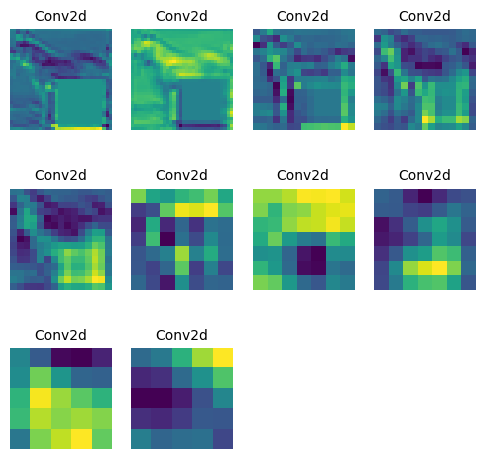

In [30]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

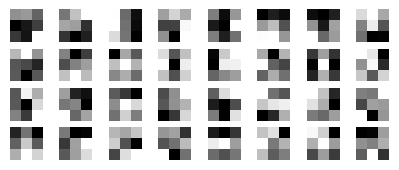

In [31]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()